# Cars: Ex post code

This code does two things: it reads in and combines datasets and it does some initial calculations using that data. 

In [1]:
import pandas as pd 
import numpy as np 

# graphs 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()

In [2]:
# read in labels (encoded in the Stata file)
lbl_vars = pd.read_stata('input/cars.dta', iterator=True).variable_labels() 
lbl_vals = pd.read_stata('input/cars.dta', iterator=True).value_labels() # the values that variables take (not relevant for all )

# add two new variable labels 
lbl_vars['s'] = 'market share (qu / qu_tot)'
lbl_vars['qu_tot'] = 'total sales in this market-year'
lbl_vars['inc'] = 'avg. income per capita'

# convert to DF 
tab_lbl_vars = pd.DataFrame(lbl_vars, index=['label']).T
tab_lbl_vars.index.name = 'variable'
tab_lbl_vals = pd.DataFrame(lbl_vals).sort_index()

# export 
tab_lbl_vars.to_csv('labels_variables.csv', index=True)
tab_lbl_vals.to_csv('labels_values.csv',    index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'input/cars.dta'

In [ ]:
cars = pd.read_excel('input/cars.xlsx')

In [ ]:
# income dataset 
inc = pd.read_csv('input/income.csv', delimiter=';')

# Make data "balanced" 

Since it is much easier to work with a dataset as a 3-dimensional array without missings, we choose `J` (the number of cars available) as the smallest number such that all market-periods have at least that many cars. It turns out `J = 40` is that number. 

There are between 40 and 102 different cars available
Smallest choiceset: UK, 1970: 40 unique car types


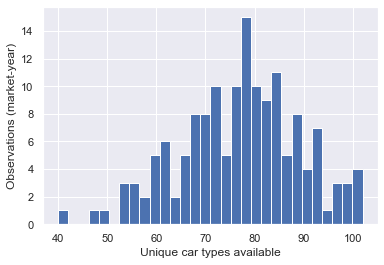

In [ ]:
# how many unique car types ("co") are available for each market-year observation? ('ma', 'ye')
c_ = cars.groupby(['ma', 'ye']).co.nunique()
ax = c_.hist(bins=30); 
ax.set_xlabel('Unique car types available'); 
ax.set_ylabel('Observations (market-year)'); 
print(f'There are between {c_.min()} and {c_.max()} different cars available')

lowest = c_[c_ == c_.min()].reset_index()
print(f'Smallest choiceset: {lbl_vals["market"][lowest.ma[0]]}, {1900 + lowest.ye[0]}: {lowest.co[0]} unique car types')

In [ ]:
# dataframe keeping only the 40 largest rows 
c = (cars.groupby(['ma', 'ye']).qu.nlargest(40) # groupby(id).var.nlargest(N) returns N values for each id
     .to_frame('Q')
     .reset_index().rename(columns={'level_2':'idx'}) # idx: index referring to the index in cars
    )

In [ ]:
# create new dummy variable
cars['among_40_largest'] = False
cars.loc[c.idx, 'among_40_largest'] = True

**Question:** What fraction of total sales do we capture with the 40 largest? 

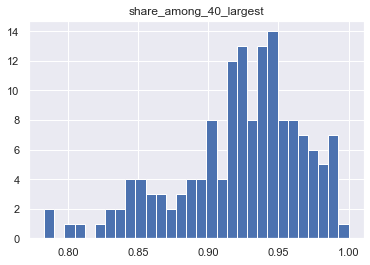

In [ ]:
c_ = cars.groupby(['ma', 'ye', 'among_40_largest']).qu.agg('sum').unstack()
c_['share_among_40_largest'] = c_.loc[:, 1] / c_.sum(1)
c_[['share_among_40_largest']].hist(bins=30); 

In [ ]:
print(f'Before: #obs. = {cars.shape[0]}, #vars = {cars.shape[1]}')

Before: #obs. = 11549, #vars = 48


### Subset original dataset

Here we keep only the 40 largest cars. 

In [ ]:
# !!! keep only observations for the 40 top-selling cars !!! 
cars = cars[cars.among_40_largest].copy()
del cars['among_40_largest']

In [ ]:
print(f'After: #obs. = {cars.shape[0]}, #vars = {cars.shape[1]}')

After: #obs. = 6000, #vars = 47


# Process income data

In [ ]:
del inc['Percentile']
inc.sample(3)

inc['ye'] = inc.Year - 1900 
del inc['Year']

# wide -> long dataset
dfs = [] 
for i,nam in lbl_vals['market'].items(): 
    nam = lbl_vals["market"][i] # string name of the market corresponding to value i 
    df = inc[['ye', lbl_vals['market'][i]]].rename(columns={nam: 'inc'})
    df['ma'] = i
    dfs.append(df)

inc = pd.concat(dfs)

cars = pd.merge(cars, inc, on=['ma', 'ye'], how='left')

In [ ]:
cars.sort_values(['ma', 'ye', 'co'], inplace=True)

In [ ]:
lbl_vars['inc'] = 'Avg. income per capita'

## Income inequality data 

Can be added from the file `income_shares.csv` if you are interested. (Not currently in use.) 

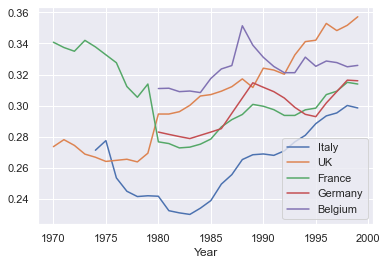

In [ ]:
pd.read_csv('input/income_shares.csv', delimiter=';').set_index('Year').query('Percentile=="p90p100"').plot();

# Market share definition 

We just take the very simplistic definition that ignores the outside option. 
$$ s_j \equiv \frac{q_j}{\sum_{k=1}^{40} q_k}. $$ 

An alternative definition would take a stance wrt. how many individuals are "in the market." For example, it could be the entire population of the country, but then that would include individuals too young to have a driver's license, etc. 

In [ ]:
cars['qu_tot'] = cars.groupby(['ma','ye']).qu.transform('sum') 
cars['s'] = cars.qu / cars.qu_tot

# Descriptive graphs

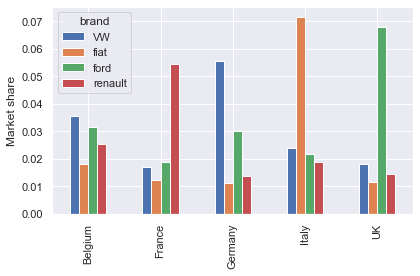

In [ ]:
I = cars.brand.isin(['renault', 'VW', 'fiat', 'ford']) # only include these brands in the plot 
ax = cars[I].groupby(['ma', 'brand']).s.mean().unstack().rename(index=lbl_vals['market']).plot(kind='bar'); 
ax.set_ylabel('Market share'); 
ax.set_xlabel(None); 
plt.tight_layout()
plt.savefig('img/home_bias.pdf'); 

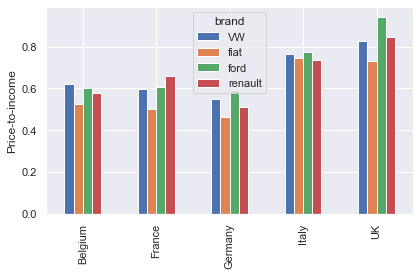

In [ ]:
I = cars.brand.isin(['renault', 'VW', 'fiat', 'ford']) # only include these brands in the plot 
ax = cars[I].groupby(['ma', 'brand']).princ.mean().unstack().rename(index=lbl_vals['market']).plot(kind='bar'); 
ax.set_ylabel('Price-to-income'); 
ax.set_xlabel(None); 
plt.tight_layout(); 
plt.savefig('img/home_price.pdf'); 

Overall market shares split by whether there is a home-market advantage. 

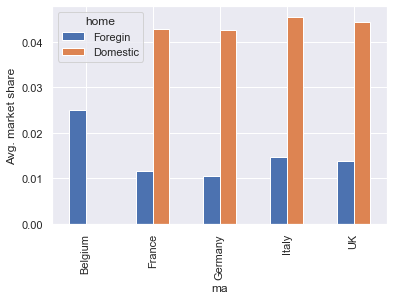

In [ ]:
ax = cars.groupby(['ma', 'home']).s.mean().unstack().rename(index=lbl_vals['market'], columns={0: 'Foregin', 1: 'Domestic'}).plot(kind='bar'); 
ax.set_ylabel('Avg. market share'); 

# Export dataset for later use 

In [ ]:
cars.to_csv('cars.csv', index=False)

In [ ]:
cars

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,pop,ngdp,rgdp,engdp,ergdp,engdpc,ergdpc,inc,qu_tot,s
21,70,1,15,14,2,audi 100/200,audi,100/200,2,4,...,9660000,1280999948288,3.940725e+12,25795239936,7.935358e+10,2670.314697,8214.65625,20363.7252,239013,0.011296
80,70,1,26,35,4,citroen 2 CV 6 - 2 CV 4,citroen,2CV6,1,3,...,9660000,1280999948288,3.940725e+12,25795239936,7.935358e+10,2670.314697,8214.65625,20363.7252,239013,0.014644
144,70,1,36,36,4,citroen dyane,citroen,dyane,1,3,...,9660000,1280999948288,3.940725e+12,25795239936,7.935358e+10,2670.314697,8214.65625,20363.7252,239013,0.028032
219,70,1,64,67,7,fiat 128,fiat,128,3,5,...,9660000,1280999948288,3.940725e+12,25795239936,7.935358e+10,2670.314697,8214.65625,20363.7252,239013,0.032634
257,70,1,71,80,8,ford escort,ford,escort,2,4,...,9660000,1280999948288,3.940725e+12,25795239936,7.935358e+10,2670.314697,8214.65625,20363.7252,239013,0.039747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5993,99,5,914,161,16,mercedes A,mercedes,A,2,4,...,58200000,889870024704,NaN,1052244508672,NaN,18079.802734,NaN,32434.8905,1635441,0.008598
5995,99,5,936,80,8,ford focus,ford,focus,7,4,...,58200000,889870024704,NaN,1052244508672,NaN,18079.802734,NaN,32434.8905,1635441,0.063119
5996,99,5,951,208,20,peugeot 206,peugeot,206,1,3,...,58200000,889870024704,NaN,1052244508672,NaN,18079.802734,NaN,32434.8905,1635441,0.035946
5998,99,5,953,282,29,toyota avensis,toyota,avensis,4,12,...,58200000,889870024704,NaN,1052244508672,NaN,18079.802734,NaN,32434.8905,1635441,0.013445
